# Remoção de *Motion Blur* Horizontal por Classificação do *Kernel* no Domínio da Frequência usando Rede Neural Convolucional
Projeto de CT-213

Contribuintes: Tafnes Silva Barbosa; Rodrigo Carvalho de Paulo

## Configuração inicial
Importa-se os módulos necessários para esse notebook

In [ ]:
# Módulos do TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import load_img, to_categorical

# Modulo Numpy para tratamento de dados
import numpy as np

# Módulo para extrair dados de arquivo .zip, usado no download de dados
import zipfile

# Módulo para tratamento de arquivos e pastas
import os
from os.path import exists

# Módulo usado para aplicar ramdomicidade
import random

# Módulo usado para aplicações matemáticas
import math

# Módulo para salvar os logs do TensorBoard de acordo com o tempo
import datetime

# Módulo para plotar imagens
import matplotlib.pyplot as plt

# Módulo da OpenCV para carregar imagens
import cv2

## Hiperparâmetros

In [ ]:
# Tamanho da imagem de entrada da rede neural treinada
img_size = (128, 128)

# Tamanho do batch usado no treinamento e validação
batch_size = 16

# Número de imagens do dataset, precolocado aqui para calcular os tamanhos dos datasets de treinamento e validação
total_num_images = 31783

# Número de batches no treinamento (igual ao número de passos para se acabar uma época)
num_train_batches = 1392

# Número imagens pertecentes ao dataset de treinamento
train_samples = batch_size * num_train_batches

# Número de imagens pertencentes ao dataset de validação
val_samples = int((total_num_images - train_samples + 1) / 2)

# Número de imagens pertencentes ao dataset de teste
test_samples = total_num_images - train_samples - val_samples

# Número de classes da classificação
n_classes = 6

# Fator de regularização L2 para os kernels da rede neural
lambd = 0

# Coeficiente angular da ativação Leaky-ReLU
alpha_leaky_relu = 0.1

# Learning rate schedule
# Começa com 'initial_lrate' e é multiplicado pela taxa 'drop' a cada 'epochs_drop' épocas
def step_decay(epoch):
    initial_lrate = 0.0000001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
# Usa função LearningRateScheduler do TensorFlow
learning_rate = LearningRateScheduler(step_decay)

# Número de épocas do treinamento
epochs = 30

## Dataset

### Baixar e extrair dados
O dataset foi criado por Tafnes e colocado numa pasta do google drive. Os dados são baixados dessa pasta.

***Precisa ativar o acesso do notebook ao drive.***

In [ ]:
# Verifica se arquivo zip existe, caso não exista, baixa os dados
if not exists("drive/MyDrive/dataset_projeto/dataset_c.zip"):
    # Baixa dados
    !gdown --id 1rIzPDpbpjjKsI4-Z4W-QvVpwG3bKqYCm

    # Extrai dataset de arquivo .zip
    with zipfile.ZipFile("dataset_c.zip","r") as zip_ref:
        zip_ref.extractall() # extracts in current directory
# Caso o caminho exista
else:
    # Extrai dataset de arquivo .zip
    with zipfile.ZipFile("drive/MyDrive/dataset_projeto/dataset_c.zip","r") as zip_ref:
        zip_ref.extractall() # extracts in current directory

# Remove o arquivo .zip baixado, caso não exista no drive
if not exists("drive/MyDrive/dataset_projeto/dataset_c.zip"):
    os.remove("dataset_c.zip")

### Preparação dos caminhos das imagens
Com os caminhos de cada imagem, cria-se um vetor com os caminhos das imagens com Motion Blur ordenados alfabeticamente.

In [ ]:
# Pasta onde as imagens estão
input_dir = "images_blurred/"

# Gera vetor com os caminhos das imagens ordenados alfabeticamente
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

# Printa o número de imagens do dataset
print("Número de imagens:", len(input_img_paths))

Número de imagens: 31783


### Classe do dataset
Cria-se a classe do dataset que vai ser usada para gerar objetos com as imagens para ser usada no treinamento e na validação.

In [ ]:
class MotionBlurDataset(keras.utils.Sequence):
    """
    Classe para iterar os dados (como Numpy arrays).
    """

    def __init__(self, batch_size, img_size, input_img_paths, n_channels=3, n_classes=6, shuffle=True):
        # Número de amostras em cada batch (type=int)
        self.batch_size = batch_size

        # Tamanho da imagem (type=(int, int))
        self.img_size = img_size

        # Vetor com os caminhos das imagens, esse vetor é mudado no final de cada época (type=list of strings)
        self.input_img_paths = input_img_paths

        # Vetor com os caminhos das imagens, esse vetor não é mudado no final de cada época
        self.input_img_paths_0 = input_img_paths

        # Número de canais das imagens de entrada da rede neural (type=int)
        self.n_channels = n_channels

        # Booleana que fala para fazer um shuffle no final de cada época, para garantir que,
        # em cada época, os batches sejam diferentes (type=bool)
        self.shuffle = shuffle

        # Número de classes no qual a rede foi treinada (type=int)
        self.n_classes = n_classes

        # Realiza processamento como se fosse o final de uma época
        self.on_epoch_end()

    def __len__(self):
        """
        Retorna o número de batches em uma época
        """
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """
        Retorna tupla (input, target) correspondente ao index (idx) do batch
        """
        i = idx * self.batch_size

        # Monta vetor com caminhos das imagens para o batch atual
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]

        # Cria os tensores de entrada da rede (x) e saída da rede (y)
        # x tem shape = (batch_size, img_size[0], img_size[1], n_channels)
        # y tem shape = (batch_size, n_classes)
        x = np.zeros((self.batch_size,) + self.img_size + (self.n_channels,), dtype="float32")
        y = np.zeros((self.batch_size,) + (self.n_classes,), dtype="int")
        for j, path in enumerate(batch_input_img_paths):
            # Carrega a imagem a ser inserida no batch e garante que ela tem o tamanho correto
            img = load_img(path, target_size=self.img_size)

            # Transforma a matriz em Numpy array do tipo float
            image = np.array(img, dtype=np.float32)

            # Aplica média aos 3 canais da imagem original para se obter uma imagem com 1 canal só (escala de cinza)
            # Aplica FFT 2D na imagem
            # Aplica módulo, pois a FFT resulta em números complexos
            # Aplica logaritmo na base 10 para se ter valores em dB (por ser fft)
            image = np.log10(np.abs(np.fft.fft2(np.mean(image, axis=2))))

            # Diminui o menor valor de toda a matriz para que o menor valor passe a ser zero
            image -= image.min(axis=0).min(axis=0)

            # Faz com que o maior valor da matriz seja igual a 1, ao final disso image tem valores entre 0 e 1
            image /= image.max(axis=0).max(axis=0)

            # Aplica um reshape para que a imagem tenha o shape com o número de canais a ser usado, nesse caso igual a 1
            x[j] = np.reshape(image, (self.img_size[0], self.img_size[1], self.n_channels))

            # Pega o label da imagem a partir do nome da imagem
            # Se o nome da imagem é 11_image, o label é 11
            # Foram usados 6 labels diferentes [3,5,7,9,11,13]
            # A função to_categorical transforma um label em um vetor de 6 unidades, por exemplo, para a imagem 11_image
            # o vetor y = [0,0,0,0,1,0]
            path_img = path[path.find("/")+1:]
            y[j] = to_categorical((int(path_img[:path_img.find("_")]) - 1 ) / 2 - 1, self.n_classes)

        return x, y

    def on_epoch_end(self):
        """
        Realiza um shuffle no vetor com os caminhos das imagens ao final de cada época,
        para garantir que os batches serão diferentes em cada época de treinamento
        """
        indexes = [*range(len(self.input_img_paths_0))]
        if self.shuffle:
            random.Random().shuffle(indexes)
            self.input_img_paths = [self.input_img_paths_0[i] for i in indexes]

### Datasets de treinamento e validação
Cria-se o validation set formado imagens aleatoriamente escolhidas, mas de forma sempre igual usando seed=1400 na função Random().

In [ ]:
# Realiza um shuffle no vetor de caminhos das imagens sempre com o mesmo seed, para sempre se ter a mesma divisão
# ou seja, o dataset de treinamento sempre terá as mesmas imagens e o de validação da mesma forma
random.Random(1400).shuffle(input_img_paths)

# Divide o vetor dos caminhos das imagens em três vetores: um para treinamento, outro para validação e outro para teste
train_input_img_paths = input_img_paths[:train_samples]
val_input_img_paths = input_img_paths[train_samples:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]

# Cria um objeto a partir da classe criada para cada um dos datasets de treinamento, validação e teste
# Ambos estão com número de classes iguais a 6 e shuffle=True, que são os defaults da classe
train_gen = MotionBlurDataset(batch_size, img_size, train_input_img_paths, n_channels=1)
val_gen = MotionBlurDataset(batch_size, img_size, val_input_img_paths, n_channels=1)
test_gen = MotionBlurDataset(batch_size, img_size, test_input_img_paths, n_channels=1)

# Printa separação proporção de separação dos dados de treinamento e validação
print("Dataset dividido em:\nTreinamento: {:2f} %\nValidação: {:2f} %\nTeste: {:2f} %".format(train_samples / total_num_images, val_samples / total_num_images, test_samples / total_num_images))

Dataset dividido em:
Treinamento: 0.700752 %
Validação: 0.149640 %
Teste: 0.149608 %


## Modelo
Definição do modelo usando Keras.

O modelo funciona para imagens de tamanho (128,128) com 1 canal de cor.

A rede usada é uma adaptação da YOLOv1 para detecção de imagens.

In [ ]:
def build_convnet_model(lambd=1e-2, alpha_leaky_relu=0.1, n_classes=6, printa_summary=True):
    """
    Função que retorna modelo a partir da estrutura adaptada da YOLOv1.

    - Todas as camadas tem seus kernels inicializados com o modo 'he_normal' (normalmente aleatório com sigma^2=2/n, onde n
    é o número de neurônios da camada).
    - Todas as camadas tem regularização L2, onde o hiperparâmetro da regularização é o lambd (float), para não se aplicar
    regularização, seta o lambd=0
    - Todas as camadas, com exceção da útlima, têm ativação igual a Leaky-ReLU, com alpha_leaky_relu (float) sendo o
    hiperparametro dessa ativação. A última camada tem a função softmax como ativação com n_classes (int) neurônios.
    """

    # Cria-se modelo usando a classe Sequential do Keras para se addicionar as camadas de forma sequencial
    convnet_model = tf.keras.models.Sequential()

    # Primeiro conjunto de convoluções até o primeiro Pooling
    convnet_model.add(layers.Conv2D(192, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd), input_shape=(128,128,1)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Segundo conjunto de convoluções até o segundo Pooling
    convnet_model.add(layers.Conv2D(128, 1, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(256, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(256, 1, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(512, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Terceiro conjunto de convoluções até o terceiro Pooling
    convnet_model.add(layers.Conv2D(256, 1, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(512, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(256, 1, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(512, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(256, 1, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(512, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(256, 1, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(512, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(512, 1, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.Conv2D(1024, 3, kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))
    convnet_model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    # Transforma saída do Pooling em um vetor para servir entrada para um rede neural totalmente conectada (FC - Fully Connected)
    convnet_model.add(layers.Flatten())

    # Primeira camada FC
    convnet_model.add(layers.Dense(units=int(n_classes*4), kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))
    convnet_model.add(layers.LeakyReLU(alpha_leaky_relu))

    # Segunda camada FC, que é a última camada da rede neural (camada de saída da rede)
    convnet_model.add(layers.Dense(units=n_classes, activation="softmax", kernel_initializer="he_normal", kernel_regularizer=regularizers.L2(lambd)))

    # Printa um resumo da rede neural criada ou printa somente a mensagem de modelo criado.
    convnet_model.summary() if printa_summary else print("Modelo criado!")

    # Salva uma imagem da rede neural com todas as suas camadas
    tf.keras.utils.plot_model(convnet_model)

    return convnet_model

### Criação da rede neural

In [ ]:
# Cria-se a rede neural a partir da função criada
# Para printar o summary depois de criado, basta dar o seguinte comando: convnet_model.summary()
convnet_model = build_convnet_model(lambd, alpha_leaky_relu, n_classes, printa_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 192)     1920      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 192)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 192)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 128)       24704     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 63, 63, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 256)       295168    
                                                        

## Compilação e Treinamento

### Compilação

In [ ]:
# Compilação do modelo usando o otimizador Adam, a perda categorical_crossentropy e a métrica de avaliação categorical_accuracy
# O learning_rate do Adam é colocado para 0, pois se usa um learning rate schedule, que é colocado nos callbacks
convnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0),
    loss="categorical_crossentropy",
    metrics=['categorical_accuracy']
)

### Callbacks

In [ ]:
# Caminho onde os valores dos weights são salvos
checkpoint_path_folder = "drive/MyDrive/dataset_projeto/checkpoint_test_epoch"
checkpoint_path = os.path.join(checkpoint_path_folder, "weights-{epoch:03d}-{val_loss:.4f}.hdf5")

# Pega qual época e qual val_loss do útlimo treinamento
weights_names = sorted(
    [
        fname
        for fname in os.listdir(checkpoint_path_folder)
        if fname.endswith(".hdf5")
    ]
)
last_epoch = int(weights_names[-1][8:11]) if len(weights_names) != 0 else 0
last_val_loss = float(weights_names[-1][12:18]) if len(weights_names) != 0 else math.inf

# Guarda o histórico do treino
history_logger = CSVLogger("drive/MyDrive/dataset_projeto/history_log.csv", separator=",", append=True)

# Callbacks a serem passados para a função de treinamento do modelo
# - O checkpoint salva somente os weights e somente quando o valor da perda do grupo de validação é menor do que já
# encontrado antes.
# - O learning_rate é o schedule criado na seção de hiperparâmetros
# - O history_logger é o histórico de treinamento para se plotar depois, onde o valor inicial é o validation loss do útlimo treinamento (initial_value_threshold)
callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, save_freq="epoch", verbose=1, initial_value_threshold=last_val_loss),
    learning_rate,
    history_logger
]

### Carrega modelo pré-treinado e treina

In [ ]:
# Gera vetor com os caminhos dos pesos ordenados alfabeticamente
weights_paths = sorted(
    [
        os.path.join(checkpoint_path_folder, fname)
        for fname in os.listdir(checkpoint_path_folder)
        if fname.endswith(".hdf5")
    ]
)
# Pega o último arquivo, referente à última época
best_weights = weights_paths[-1] if len(weights_paths) != 0 else ""

# Carrega os pesos do melhor treinamento anterior ou começa do zero
if len(best_weights) != 0:
    convnet_model.load_weights(best_weights)
    print("Usando pesos de treinamento anterior")
else:
    print("Treinando do zero")

# Número de passos por época do treinamento (número de batches)
steps_per_epoch_train = len(train_gen)
# Número de passos por época do treinamento (número de batches)
steps_per_epoch_val = len(val_gen)

Usando pesos de treinamento anterior


In [ ]:
# Treina o modelo, fazendo uma validação no fim de cada época
# O shuffle está False, pois a classe criada já realiza o shuffle no final de cada época
# O treinamento começa a partir da última época treinada anteriormente
convnet_model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=val_gen,
    callbacks=callbacks,
    shuffle=False,
    validation_steps=steps_per_epoch_val,
    initial_epoch=last_epoch
)

## Testando o modelo

In [ ]:
# Testa o modelo treinado no dataset de teste
loss_accuracy = convnet_model.evaluate(test_gen)

# Printa a perda e a acurácia do dataset de teste
print("\nPerda do dataset de teste: {:5f}".format(loss_accuracy[0]))
print("Acurácia do dataset de teste: {:5f}".format(loss_accuracy[1]))

297/297 [==============================] - 27s 56ms/step - loss: 0.0133 - categorical_accuracy: 0.9985

Perda do dataset de teste: 0.013300
Acurácia do dataset de teste: 0.998527


## Recuperando a imagem
Sabendo o tamanho do kernel usado, é possível recuperar a imagem original.

Uma convolução do kernel $$A=\left[\begin{array}{ccc}
0&0&0\\
1&1&1\\
0&0&0
\end{array}\right]_{(2p+1\times 2p+1)}$$com uma imagem (com *zero padding*) pode ser entendida da seguinte maneira:
$$Y=(HX^{T})^{T}$$onde $X_{(M\times N)}$ é a imagem original e $Y$ é a imagem com motion blur e tem-se que:
$$
H=\frac{1}{2p+1}\cdot\left[\begin{array}{cccccc}
1&1&1&0&\cdots&0\\
0&1&1&1&\cdots&0\\
0&0&1&1&\cdots&0\\
\vdots&\vdots&\vdots&\vdots&\ddots&\vdots\\
0&0&0&0&\cdots&1
\end{array}\right]_{(N\times N+2p)}
$$

Como $H$ é uma matriz singular, sua inversa não existe, mas a sua pseudo-inversa (Moore-Penrose inversa) sim e é dada por:
$$
H^{+}=\left(H^{T}H\right)^{-1}H^{T}
$$
Em python, basta usar o comando: Hplus = numpy.linalg.pinv(H).

Assim $X$ pode ser recuperado ao se aplicar: $$X=(H^{+}Y^{T})^{T}$$

Esse método garante o menor erro quadrático entre o obtido e o original.

In [ ]:
def inverse_mask(kernel_size, image_blur):
    """
    Função que retorna imagem recuperada ao receber imagem com motion blur e o tamanho do kernel pelo o qual o motion blur foi introduzido
    """

    # Descobre o valor de p
    p = int((kernel_size - 1) / 2)

    # Formato da imagem
    M = image_blur.shape[0]
    N = image_blur.shape[1]

    # Cria a matriz H, como mostrada acima
    H = np.zeros((M, N + kernel_size - 1))
    for i in range(M):
        H[i, i:i+kernel_size] = np.ones((1, kernel_size)) / kernel_size

    # Cria a pseudoinversa de H
    Hplus = np.linalg.pinv(H)

    # Aplica a pseudoinversa para se obter a imagem original
    image = np.zeros((M, N + kernel_size - 1, 3))
    for i in range(3):
        aux = Hplus @ image_blur[:,:,i].T
        image[:,:,i] = aux.T
    return image

### Exemplo de aplicação
Agora, mostra-se um exemplo de como esse processo funciona. Mas primeiramente, monta-se a função que aplica motion blur.

In [ ]:
def apply_motion_blur(input_image, ks=5, horizontal=True):
    """
    Função que aplica motion blur na horizontal, onde ks é o tamanho do kernel.
    """
    # Tamanho do kernel
    kernel_size = ks

    # Cria-se o kernel
    kernel = np.zeros((kernel_size, kernel_size))

    # Preenche o meio do kernel com 1s
    if horizontal:
        kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    else:
        kernel[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)

    # Normaliza para que a convolução tenha média igual à função de entrada
    kernel /= kernel_size

    # Aplica o kernel criado por convolução.
    output_image = cv2.filter2D(input_image, -1, kernel)

    return output_image

Plota-se a imagem sem motion blur e depois com motion blur

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1C7Lnt4MsUb6VKV6znIMKtj_JBRiNl1jF
To: /content/36979.jpg
100% 11.0k/11.0k [00:00<00:00, 42.5MB/s]
Imagem original:


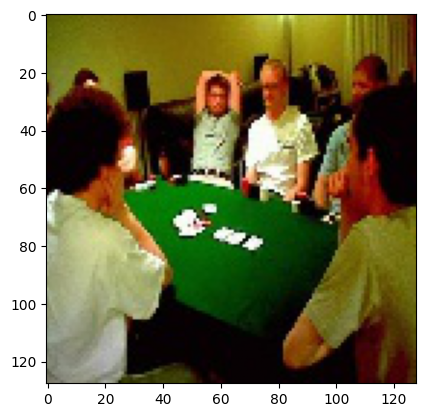

Imagem com motion blur:


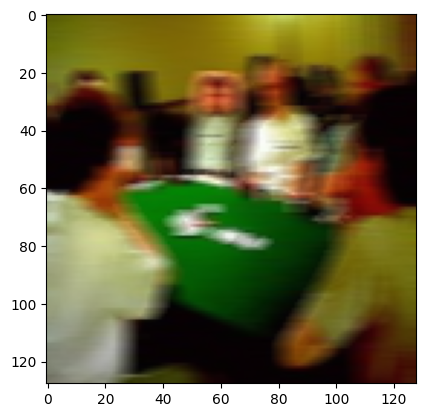

In [ ]:
# Baixa e carrega imagem de teste
!gdown --id 1C7Lnt4MsUb6VKV6znIMKtj_JBRiNl1jF
image = np.array(load_img("36979.jpg")) / 255.0

# Aplica motion blur à imagem de teste
output_image = apply_motion_blur(image, ks=9, horizontal=True)

# Plota imagem teste
print("Imagem original:")
plt.figure()
plt.imshow(image)
plt.show()

# Plota imagem teste com motion blur
print("Imagem com motion blur:")
plt.figure()
plt.imshow(output_image)
plt.show()

Agora, recupera-se a imagem através do método mencionado

Imagem recuperada:


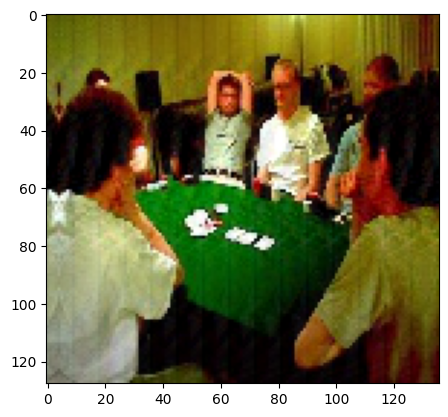

In [ ]:
# Aplica-se a função de recuperação para se obter a imagem recuperada
image_rec = inverse_mask(9, output_image)

# Plota imagem recuperada
print("Imagem recuperada:")
plt.figure()
plt.imshow(image_rec)
plt.show()

### Aplicação nas imagens do Dataset
As imagens do dataset foram salvas em JPG, o que faz com que as imagens percam qualidade, que é o mesmo que inserir um ruído na imagem. Abaixo mostra-se o resultado aplicado à mesma imagem, mas vinda do dataset.

Imagem do dataset:


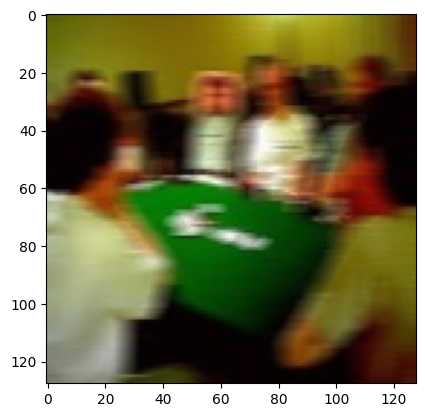

In [ ]:
# Carrega imagem do dataset
image_dataset = np.array(load_img("images_blurred/9_36979_blurred.jpg")) / 255.0

# Plota imagem do dataset
print("Imagem do dataset:")
plt.figure()
plt.imshow(image_dataset)
plt.show()

Agora, recupera-se a imagem através do método mencionado:

Imagem recuperada:


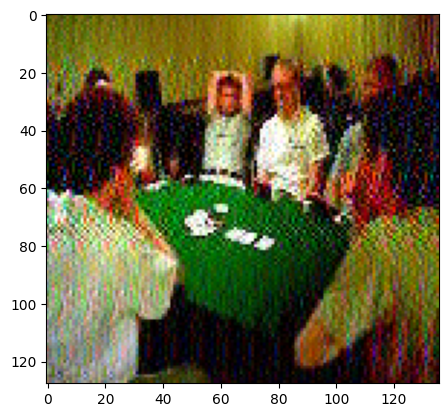

In [ ]:
# Aplica-se a função de recuperação para se obter a imagem recuperada
image_rec_dataset = inverse_mask(9, image_dataset)

# Plota imagem recuperada
print("Imagem recuperada:")
plt.figure()
plt.imshow(image_rec_dataset)
plt.show()